In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## os.listdir(path) returns a list containing the names of the entries in the directory given by path
datapath='../Downloads/Data/'
group_folder = os.listdir(datapath)
group_folder.sort()
# print(group_folder)

In [3]:
# variables which are used globally

AE=1
VDISP=2
PWR=3
MIC=4
Fs = 250000

data_path_dict = { i:{ j:datapath+group_folder[i-1]+'/'+'level '+str(j)+'/' for j in range(3)}  for i in range(1,6)}
tool_wear_group = {'nhna':[3,4],'nhoa':[2],'ohna':[1],'ohoa':[5]}
tool_wear = list(tool_wear_group.keys())

data_buf_in_mem = { wear:{cont_lv:[] for cont_lv in range(3)} for wear in tool_wear} # data buffer in memory

In [4]:
def read_data_into_mem(tool, contam, buf=data_buf_in_mem, max_file_num=None):
    # read a certain part of data into memory, which greatly reduces the time spent on data read-in
    # if you have free memory of greater than 3GB, keeping all data in the memory will save your time when generating figures
    # if your memory is insufficient you may read the part that is frequently used, and clear them after they are no longer needed
    # e.g. tool = ['nhna', 'ohoa'], contam = [2]
    
    global data_buf_in_mem, data_path_dict, tool_wear_group
    
    for wear in tool:
        for cont_lv in contam:
            levels_folder = [data_path_dict[i][cont_lv] for i in tool_wear_group[wear]]
            buf[wear][cont_lv].clear() # clear the existing data; might be a bit inefficient but makes programming much easier
                                       # otherwise running this read_in several times could result in duplication
            for folder in levels_folder:
                file_list = os.listdir(folder) 
                file_list.sort()
                for f in file_list[:max_file_num]:
                    weld_data = pd.read_csv(folder + f, delimiter = ',').values
                    buf[wear][cont_lv].append(weld_data)

def clear_data_in_mem(tool, contam, buf=data_buf_in_mem):
    # clear the selected part of data (which exists in memory)
    global data_buf_in_mem, data_path_dict, tool_wear_group
    for wear in tool:
        for cont_lv in contam:
            buf[wear][cont_lv].clear()

T = 0.5; # default sampling interval
def align_data(tool, contam, t_left=0.01, t_right=0.49, align_channel=PWR, threshold=0.5, buf=data_buf_in_mem):
    # align the selected part of data using the power channel
    # default: left 0.01 secs; right 0.49 secs
    global data_buf_in_mem, data_path_dict, tool_wear_group, Fs
    for wear in tool:
        for cont_lv in contam:
            sample_num = len(buf[wear][cont_lv])
            for i in range(sample_num):
                data = buf[wear][cont_lv][i]
                
                align_sig = data[:,align_channel]
                loc = np.where(align_sig == align_sig[align_sig > threshold][0])[0][0]
                loc_l = int(loc-t_left*Fs)
                loc_r = int(loc+t_right*Fs)
                
                temp = data[loc_l:loc_r,:]
                temp[:,0] = data[:loc_r-loc_l,0]
                buf[wear][cont_lv][i] = temp
                
                

In [5]:
def power_density_spectrum(sig):
    n=len(sig)
    Y = np.fft.fft(sig) # n-point discrete Fourier transform via FFT
    Y = Y / np.sqrt(n) # regularize the spectrum to preserve energy
    Y = abs(Y*Y)
    Y[1:int((n-1)/2)+1] *= 2 # freq=0 & freq=(1+k) when n=2k+1 component should not be doubled after taking a single side
    return Y[:int(n/2)+1] # signal power density spectrum


In [6]:
def calc_savgo_filter_coef(M, nl, nr):
    # coefficients of savitzky-golay smooting filter
    # refer to https://www.wire.tu-bs.de/OLDWEB/mameyer/cmr/savgol.pdf
    # matrix A.transpose() here is the matrix A in the document above
    a = np.array(range(nl+nr+1))-nl
    A = np.array( [np.power(a, j) for j in range(M+1)] )
    tmp = np.linalg.inv( np.matmul(A, A.transpose()) )
    c = np.matmul(tmp[0], A)
    return c

def savgo_smoothing(nl, nr, c, seq):
    # using savgo filter c to smooth seq
    # zero-padding
    l = len(seq)
    tmp = np.zeros(l+nl+nr)
    for i in range(nl+nr+1):
        tmp[i:i+l] += seq*c[-i-1]
    return tmp[nr:nr+l]

In [7]:
# import time
# start = time.time()
read_data_into_mem(tool_wear,list(range(3))) # read all data into memory. good if your free memory size>4GB
# end = time.time()
# print(end - start)

# print(len(data_buf_in_mem['nhna'][0][2]), data_buf_in_mem['nhna'][0][2].size)
# [[len(data_buf_in_mem[wear][lv]) for lv in list(range(3))] for wear in tool_wear ]

align_data(tool_wear,list(range(3)))

# [[[a.shape for a in data_buf_in_mem[wear][lv]] for lv in list(range(3))] for wear in tool_wear ]

# clear_data_in_mem(tool_wear, list(range(3)))

In [8]:
n = int(Fs*T); # length of the signal
k = np.arange(n);

t = k/Fs; # time vector
frq = k/T; # two sides frequency range
frq = frq[range(int(n/2)+1)] # one side frequency range
index_20kHz = int(20000*T)

seg=list(range((index_20kHz - 100),(index_20kHz + 100)));
# (M,nl,nr)=(4,8,8)
(M,nl,nr)=(4,12,12)
c=calc_savgo_filter_coef(M,nl,nr)

In [38]:
channel = AE

peak_freq_dict={}
peak_freq_power_dict={}

for wear in tool_wear:
# for wear in ['ohoa']:
    pkfreq_tmp=[ [] for j in range(3) ]
    pkpwr_tmp=[ [] for j in range(3) ]
    peak_freq_dict[wear] = pkfreq_tmp
    peak_freq_power_dict[wear] = pkpwr_tmp
    
    for j in range(3):
        for data in data_buf_in_mem[wear][j]:
            signal = data[:,channel]
            signal = signal-np.mean(signal)
            Y = power_density_spectrum(signal)
            yfilt=savgo_smoothing(nl,nr,c,Y[seg]);

#             fig, ax = plt.subplots(2, 1, figsize = (16, 6))
#             ax[0].plot(t,signal)
#             ax[0].set_xlabel('Time')
#             ax[0].set_ylabel('Amplitude')
#             time_pwr=sum(x*x for x in signal) # signal average power calculated in time domain
#             print(time_pwr)
            
#             ax[1].plot(frq[seg],Y[seg],'r') # plotting the spectrum
#             ax[1].plot(frq[seg],yfilt,'b') # plotting the spectrum
#             ax[1].set_xlabel('Freq (Hz)')
#             ax[1].set_ylabel('|Y(freq)|')
# #             fq_pwr=sum(x*x for x in Y) / n *2 # signal average power calculated in freq domain
#             fq_pwr=sum(Y) # signal average power calculated with power densigy spectrum
#             print(fq_pwr,'\n')

#             plt.show()

            peak_freq_power = np.max(yfilt) # peak power density
            peak_freq = frq[np.where(yfilt == peak_freq_power)[0] + (index_20kHz - 100)]
            pkfreq_tmp[j].append(peak_freq.item())
            pkpwr_tmp[j].append(peak_freq_power.item())
            
            

<function matplotlib.pyplot.show(*args, **kw)>

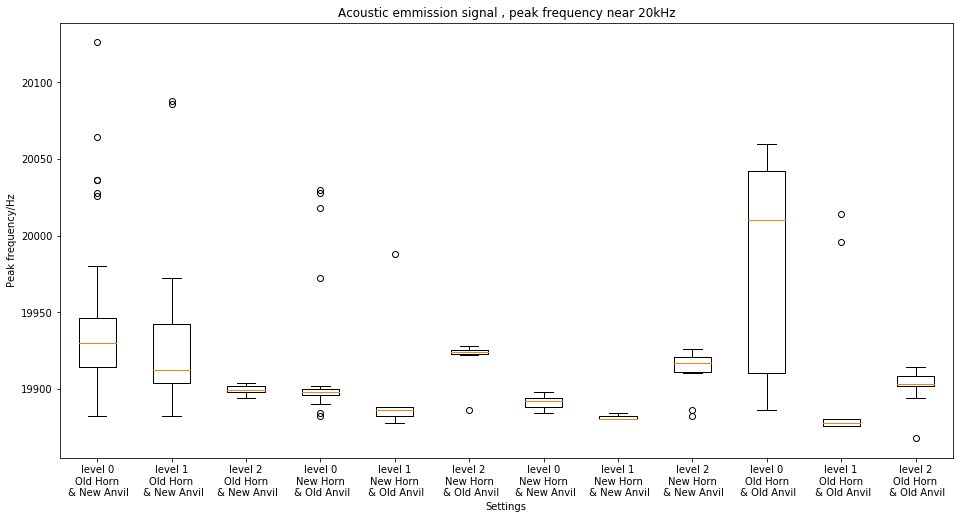

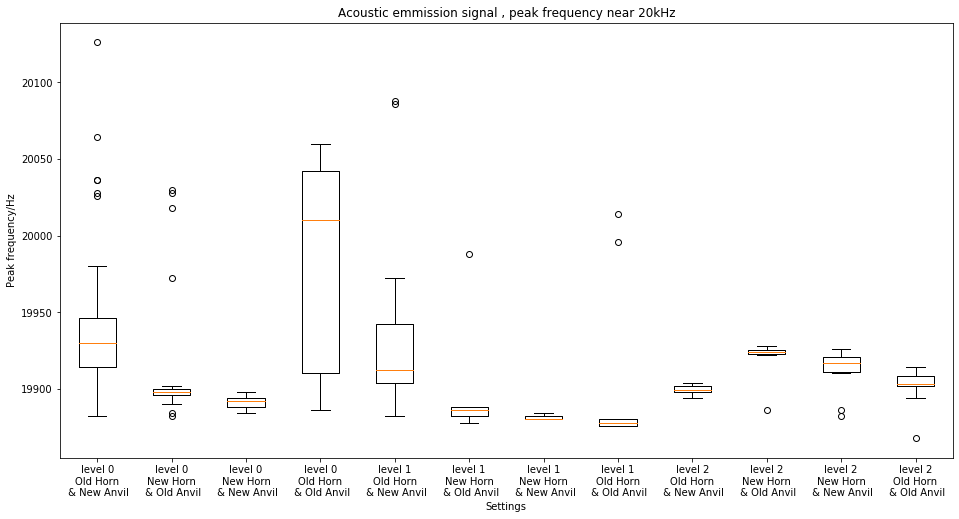

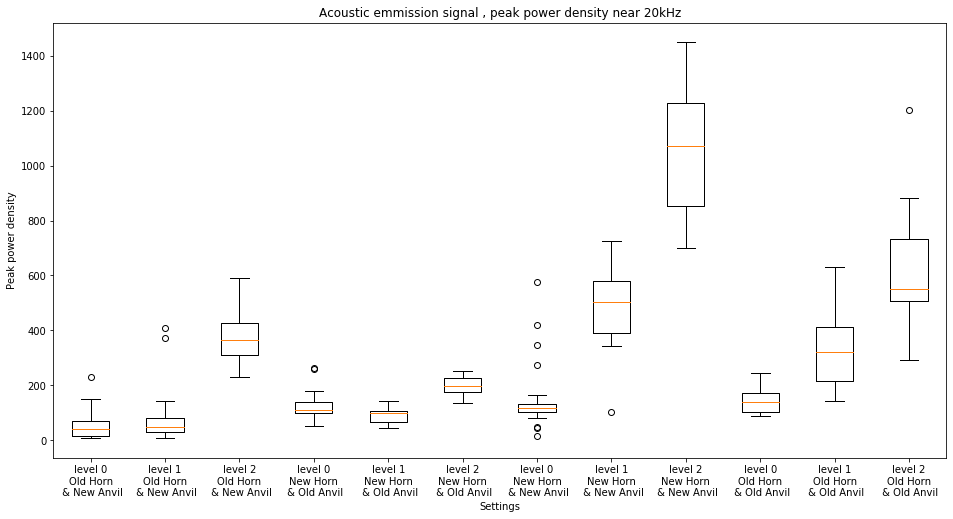

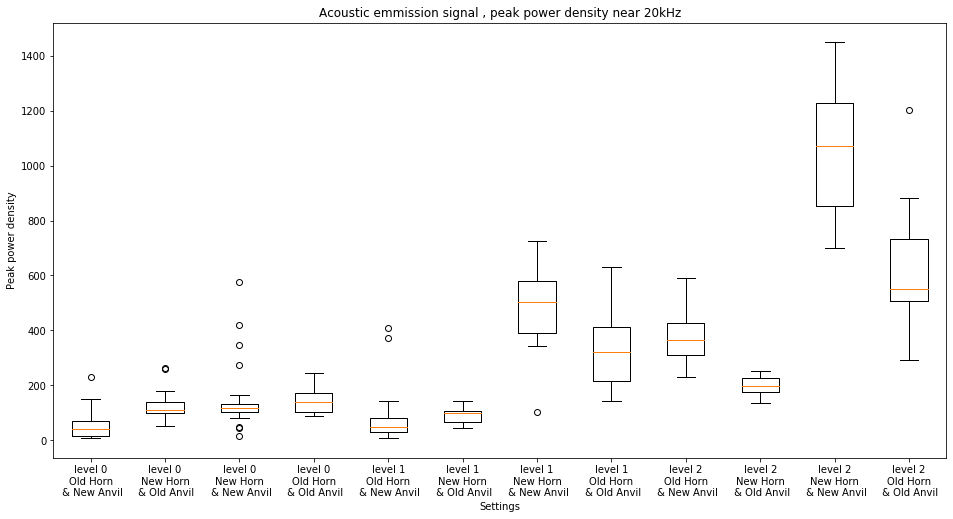

In [39]:

a='New'
b='Old'
s='{h} Horn\n & {an} Anvil'
wear_contition= [s.format(h=x[0],an=x[1]) for x in [[b,a],[a,b],[a,a],[b,b]]]
lbls1 = ['level '+str(j)+'\n'+wear_contition[i] for i in range(4) for j in range(3)]
lbls2 = ['level '+str(j)+'\n'+wear_contition[i] for j in range(3) for i in range(4)]
channel_name='Acoustic emmission signal'

peak_freq_list1 = [item for wear in tool_wear for item in peak_freq_dict[wear]]
peak_pwr_list1 = [item for wear in tool_wear for item in peak_freq_power_dict[wear]]
peak_freq_list2 = [peak_freq_list1[i*3+j] for j in range(3) for i in range(4)]
peak_pwr_list2 = [peak_pwr_list1[i*3+j] for j in range(3) for i in range(4)]

fig = plt.figure(figsize=(16,8))
plt.boxplot(peak_freq_list1, labels=lbls1)
plt.xlabel('Settings')
plt.ylabel('Peak frequency/Hz')
plt.title(channel_name+' , peak frequency near 20kHz')
plt.show

fig = plt.figure(figsize=(16,8))
plt.boxplot(peak_freq_list2, labels=lbls2)
plt.xlabel('Settings')
plt.ylabel('Peak frequency/Hz')
plt.title(channel_name+' , peak frequency near 20kHz')
plt.show

fig = plt.figure(figsize=(16,8))
plt.boxplot(peak_pwr_list1, labels=lbls1)
plt.xlabel('Settings')
plt.ylabel('Peak power density')
plt.title(channel_name+' , peak power density near 20kHz')
plt.show

fig = plt.figure(figsize=(16,8))
plt.boxplot(peak_pwr_list2, labels=lbls2)
plt.xlabel('Settings')
plt.ylabel('Peak power density')
plt.title(channel_name+' , peak power density near 20kHz')
plt.show


In [26]:
channel = MIC

peak_freq_dict={}
peak_freq_power_dict={}

for wear in tool_wear:
    pkfreq_tmp=[ [] for j in range(3) ]
    pkpwr_tmp=[ [] for j in range(3) ]
    peak_freq_dict[wear] = pkfreq_tmp
    peak_freq_power_dict[wear] = pkpwr_tmp
    
    for j in range(3):
        for data in data_buf_in_mem[wear][j]:
            signal = data[:,channel]
            signal = signal-np.mean(signal)
            Y = power_density_spectrum(signal)
            yfilt=savgo_smoothing(nl,nr,c,Y[seg]);

#             fig, ax = plt.subplots(2, 1, figsize = (16, 6))
#             ax[0].plot(t,signal)
#             ax[0].set_xlabel('Time')
#             ax[0].set_ylabel('Amplitude')
#             time_pwr=sum(x*x for x in signal) # signal average power calculated in time domain
#             print(time_pwr)
            
#             ax[1].plot(frq[seg],Y[seg],'r') # plotting the spectrum
#             ax[1].plot(frq[seg],yfilt,'b') # plotting the spectrum
#             ax[1].set_xlabel('Freq (Hz)')
#             ax[1].set_ylabel('|Y(freq)|')
# #             fq_pwr=sum(x*x for x in Y) / n *2 # signal average power calculated in freq domain
#             fq_pwr=sum(Y) # signal average power calculated with power densigy spectrum
#             print(fq_pwr,'\n')

#             plt.show()

            peak_freq_power = np.max(yfilt) # peak power density
            peak_freq = frq[np.where(yfilt == peak_freq_power)[0] + (index_20kHz - 100)]
            pkfreq_tmp[j].append(peak_freq.item())
            pkpwr_tmp[j].append(peak_freq_power.item())
            
            

<function matplotlib.pyplot.show(*args, **kw)>

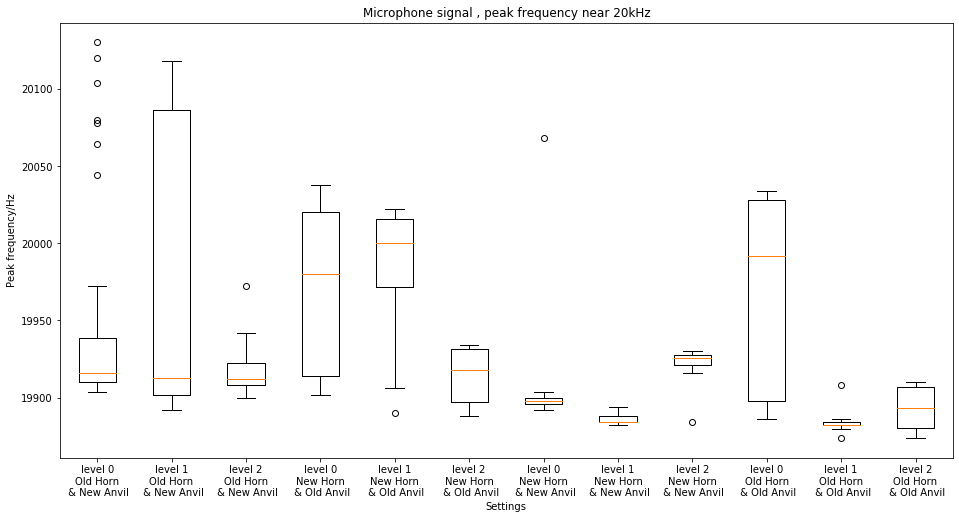

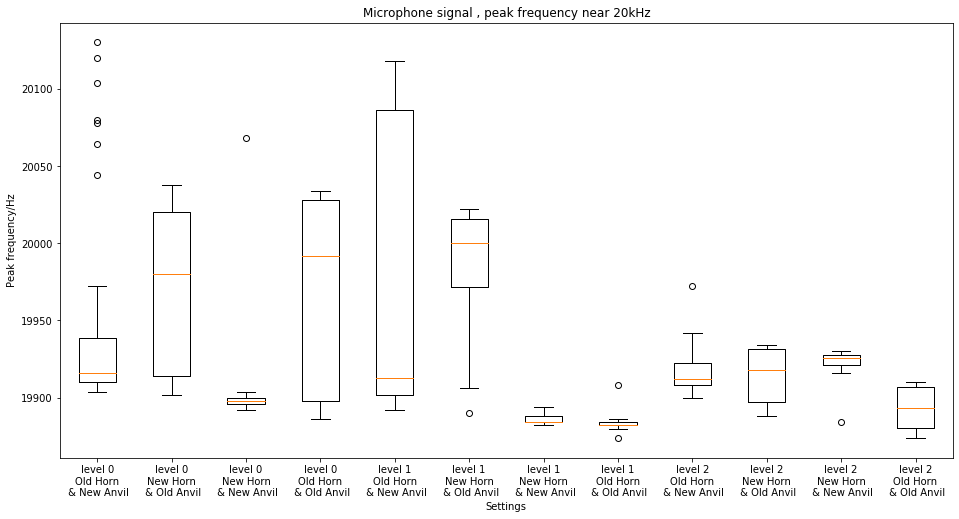

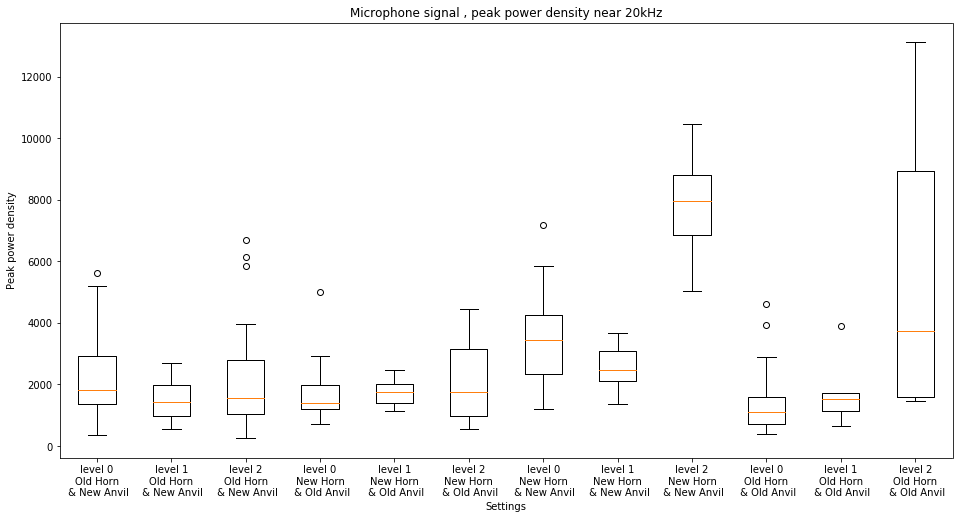

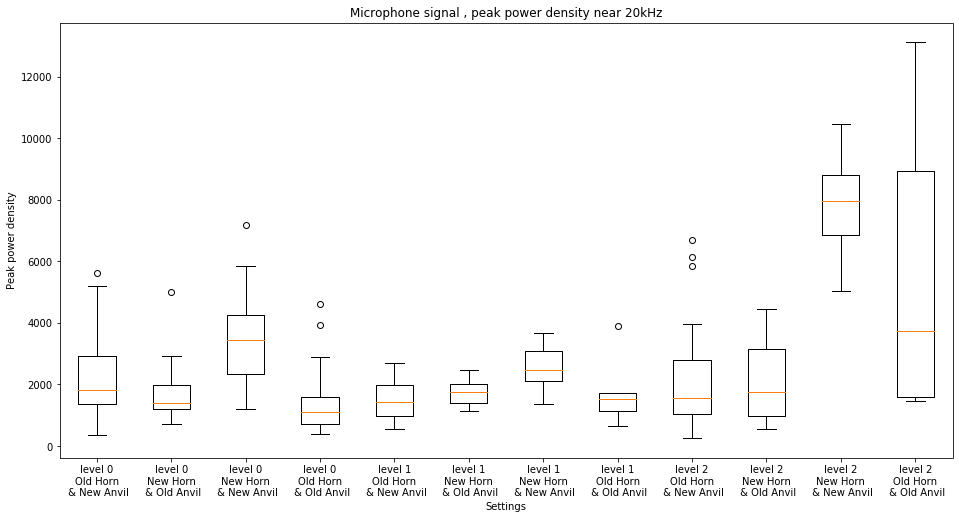

In [35]:

a='New'
b='Old'
s='{h} Horn\n & {an} Anvil'
wear_contition= [s.format(h=x[0],an=x[1]) for x in [[b,a],[a,b],[a,a],[b,b]]]
lbls1 = ['level '+str(j)+'\n'+wear_contition[i] for i in range(4) for j in range(3)]
lbls2 = ['level '+str(j)+'\n'+wear_contition[i] for j in range(3) for i in range(4)]
channel_name='Microphone signal'

peak_freq_list1 = [item for wear in tool_wear for item in peak_freq_dict[wear]]
peak_pwr_list1 = [item for wear in tool_wear for item in peak_freq_power_dict[wear]]
peak_freq_list2 = [peak_freq_list1[i*3+j] for j in range(3) for i in range(4)]
peak_pwr_list2 = [peak_pwr_list1[i*3+j] for j in range(3) for i in range(4)]

fig = plt.figure(figsize=(16,8))
plt.boxplot(peak_freq_list1, labels=lbls1)
plt.xlabel('Settings')
plt.ylabel('Peak frequency/Hz')
plt.title(channel_name+' , peak frequency near 20kHz')
plt.show

fig = plt.figure(figsize=(16,8))
plt.boxplot(peak_freq_list2, labels=lbls2)
plt.xlabel('Settings')
plt.ylabel('Peak frequency/Hz')
plt.title(channel_name+' , peak frequency near 20kHz')
plt.show

fig = plt.figure(figsize=(16,8))
plt.boxplot(peak_pwr_list1, labels=lbls1)
plt.xlabel('Settings')
plt.ylabel('Peak power density')
plt.title(channel_name+' , peak power density near 20kHz')
plt.show

fig = plt.figure(figsize=(16,8))
plt.boxplot(peak_pwr_list2, labels=lbls2)
plt.xlabel('Settings')
plt.ylabel('Peak power density')
plt.title(channel_name+' , peak power density near 20kHz')
plt.show
